# Identificação de Sistemas - ARX System Identification

## Exemplo de identificação de um sistema usando modelo ARX - cálculo "usando apenas NUMPY"

### Etapas

* leitura de dados de variáveis de processo, procedentes de testes em planta (simulada) que foram armazenados em um servidor OPC UA (EPM - PIMS da Elipse Software)
* remoção do ruído de medida (filtro média móvel)
* visualização do gráfico de tendência das variáveis de processo (lidas e filtradas)
* construção da matriz de regressores
* estimação dos parâmetros por mínimos quadrados (pseudo inversa)
* simulação utilizando o modelo
* visualização do gráfico de tendência dos dados de processo e do resultado da simulação a aprtir do modelo estimado.

ref.:
Estimação de modelos ARX - https://youtu.be/cVFb-ndczTU - (canal no Youtube de Luis Antonio Aguirre)

## ARX: AutoRegressive with eXternal (ou eXogenous) input

$A(q) y(k) = B(q) u(k) + \nu(k)$

onde $A(q)$ e $B(q)$ são dados por:

$A(q)$: $1 - a_1 q^{-1} - a_2 q^{-2} ...$

$B(q)$: $b_1 q^{-1} + b_2 q^{-2} ...$

* termo Auto Regressivo: $A(q) y(k)$
* termo Exógeno: $B(q) * u(k)$
* erro de caráter aleatório (ruído branco): $\nu(k)$

Equação de regressão (das diferenças):

$y(k) = a_1 y(k-1) + a_2 y(k-2) + ... + b_1 u(k-1) + b_2 u(k-2) + ...$

Na forma matricial:

$Y_s = \phi \theta$

onde:

$\phi$: matriz dos regressores (com dados de estimação de $\theta$)

$\theta$: vetor dos parâmetros

Estimando os parâmetros por mínimos quadrados (cálculo da pseudo inversa)

$\theta_{est} = [\phi^T \phi]^{-1} \phi^T Y$

In [1]:
%matplotlib inline
try:
    import numpy as np
    import datetime
    import matplotlib.pyplot as plt
    import epmwebapi as epm
    import getpass
    print('Módulos importados com sucesso!')
except ImportError as error:
    print('Erro na importação!')
    print(error.__class__.__name__ + ': ' + error.message)
except Exception as exception:
    print(exception.__class__.__name__ + ': ' + exception.message)

Módulos importados com sucesso!


In [2]:
# ATENÇÃO:
# Para uso em produção, é recomendado usar variáveis de ambiente para buscar informações de Usuário/Senha.
# Para este minicurso será utilizado as funções input e getpass
user = input('EPM user:')
password = getpass.getpass("EPM password:")
epm_auth = 'http://epmtr.elipse.com.br/auth' # 'http://localhost:44333'
epm_web  = 'http://epmtr.elipse.com.br'# 'http://localhost:44332'

# Criação de uma conexão informando os endereços do EPM Webserver(Authentication Port e WEB API Port), usuário e senha.
try:
    epmConn = epm.EpmConnection(epm_auth, epm_web, user, password)
    # A forma mais recomendada (fácil) para usar o comando print é com fstring
    print(f'Conexão com {epm_web} criada com sucesso para o usuário {user}.')
except:
    print(f'Falha no estabelecimento da conexão com {epm_web} para o usuário {user}.')

EPM user:mauricio
EPM password:········
Conexão com http://epmtr.elipse.com.br criada com sucesso para o usuário mauricio.


## Lendo dados do servidor OPC UA (EPM - PIMS da Elipse Software)

In [3]:
# Lista com os nomes das variáveis de interesse
bvList = ['LIC101', 'FIC101']
# Dicionário com as variáveis - Basic Variables
bvDic = epmConn.getDataObjects(bvList)
bv_LIC101 = bvDic[bvList[0]]
bv_FIC101 = bvDic[bvList[1]]
# Definição do período da consulta (em UTC)
ini_date = datetime.datetime(2014, 3, 4, 2, 5, tzinfo=datetime.timezone.utc)
end_date = datetime.datetime(2014, 3, 4, 4, tzinfo=datetime.timezone.utc)
query_period = epm.QueryPeriod(ini_date, end_date)
# Definição do intervalo de processamento para usar na agregação (padrão OPC UA)
process_interval = datetime.timedelta(seconds=1)
# Definição do tipo de agregação (padrão OPC UA)
aggregate_details = epm.AggregateDetails(process_interval, epm.AggregateType.Interpolative)
# Consultas agregadas da PV e da MV - dados provenientes de testes em planta (simulada)
data_y = bv_LIC101.historyReadAggregate(aggregate_details, query_period)
data_u = bv_FIC101.historyReadAggregate(aggregate_details, query_period)
# Encerrando a conexão para liberar a sessão para outros usuários
epmConn.close()
print('Dados de processo lidos e conexão encerrada!!')

Dados de processo lidos e conexão encerrada!!


## Definindo uma função de filtro de média móvel

In [4]:
# Filtro de media movel de ordem "o"
def filtMean( xo, o ):
    x = xo.copy() # copia os dados para nao alterar a vairavel do console
    X = x.copy()
    for i in range( 1, o ):
        tmp = np.hstack( (x[i:], np.zeros(i)) )
        X += tmp
    X /= o
    # Repete a ultima media para os valores finais
    lastM = X[-o]
    for i in range( 1, o ):
        X[-i] = lastM
    return X
print('Função definida no escopo com sucesso!!!')

Função definida no escopo com sucesso!!!


## Filtrado o ruído de medida usando a função definida anteriormente

## Apresentando so resultados em um gráfico de tendência

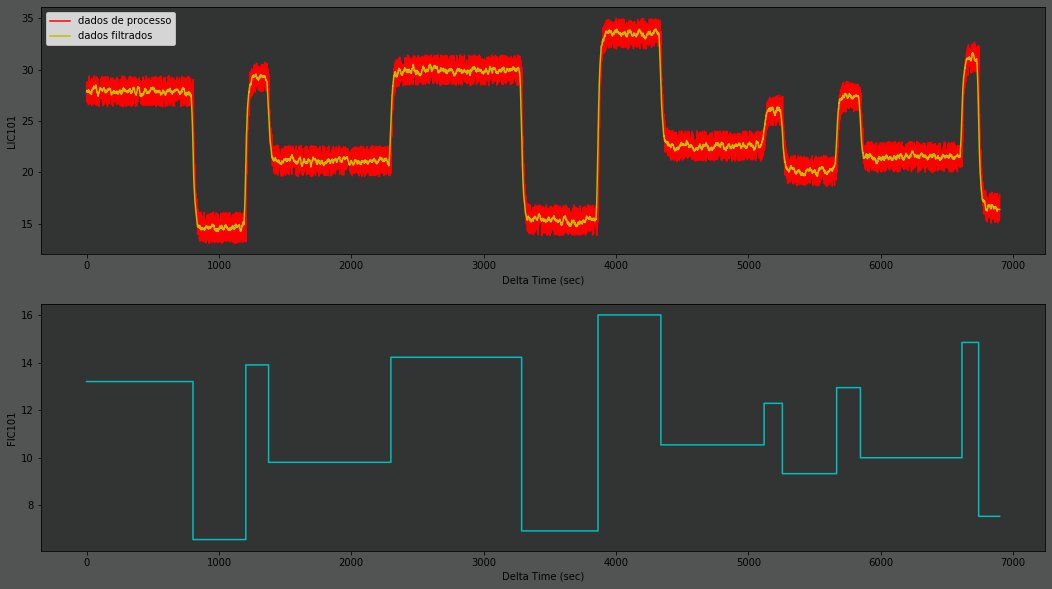

In [5]:
data_yf = filtMean(data_y['Value'], 18)
t = np.arange(len(data_yf))
fig, ax = plt.subplots(2, 1)
ax[0].plot(t,data_y['Value'],color='r',label='PV')
ax[0].plot(t,data_yf,'y',label='PVf')
ax[0].set_xlabel('Delta Time (sec)')
ax[0].set_ylabel(bv_LIC101.name)
ax[1].step(t,data_u['Value'], where='pre', color='c',label='MV')
ax[1].set_xlabel('Delta Time (sec)')
ax[1].set_ylabel(bv_FIC101.name)
fig.set_size_inches(18, 10)
fig.patch.set_facecolor('#525454')
ax[0].set_facecolor('#323434')
ax[1].set_facecolor('#323434')
ax[0].legend(['dados de processo', 'dados filtrados'])

## Montando a matriz de regressores

In [6]:
na = 2
nb = 2
y_k = np.reshape(data_yf.copy(), (-1,1))
yb = y_k[0][0]
y_k -= yb
u_k = np.reshape(data_u['Value'].copy(), (-1,1))
ub =u_k[0][0]
u_k -= ub
nk = len(y_k)
y_s = y_k[na+1:]
ns = len(y_s)
# Matriz dos regressores - com os "dados de estimação" Y_s e U_s
phi = np.empty((ns, na + nb), dtype=float)

# Vetor com os parâmetros a serem estimados
theta = np.empty((na + nb, 1), dtype=float)

col = 0
for i in range(na):
    phi[:, col] = y_k[na-i:ns+na-i].flatten()
    col += 1
col = na + nb - 1
for i in range(nb):
    phi[:, col] = u_k[nb-i:ns+nb-i].flatten()
    col -= 1
print('Matriz PHI de regressão construída!')

Matriz PHI de regressão construída!


## Estimativa usando Mínimos Quadrados (cálculo da Pseudo Inversa)

In [7]:
theta_mq = np.dot(np.dot(np.linalg.inv(np.dot(phi.T, phi)), phi.T), y_s)
print('Parâmetros estimados com sucesso!')
print(theta_mq)

Parâmetros estimados com sucesso!
[[ 1.53042662]
 [-0.5387326 ]
 [-0.03622098]
 [ 0.05242193]]


## Simulando a partir do modelo identificado

In [8]:
# Função auxiliar para cálculo da predição de um passo à frente
def dif_eq_yk(yk_1, yk_2, uk_1, uk_2, theta_mq):
    a1 = theta_mq[0]
    a2 = theta_mq[1]
    b1 = theta_mq[2]
    b2 = theta_mq[3]
    return a1*yk_1 + a2*yk_2 + b1*uk_1 + b2*uk_2
    
# Inicializa o Y estimado pelo modelo
y_h = np.empty_like(y_k)
y_h[0] = y_k[0]
y_h[1] = y_k[1]
y_h[-3:] = y_k[-3:]

for i in range(na, ns):
    y_h[i] = dif_eq_yk(y_h[i-1], y_h[i-2], u_k[i-1], u_k[i-2], theta_mq)
print('Simulação finalizada com sucesso!!')

Simulação finalizada com sucesso!!


## Visualizando o resultado dados de processo X simulação

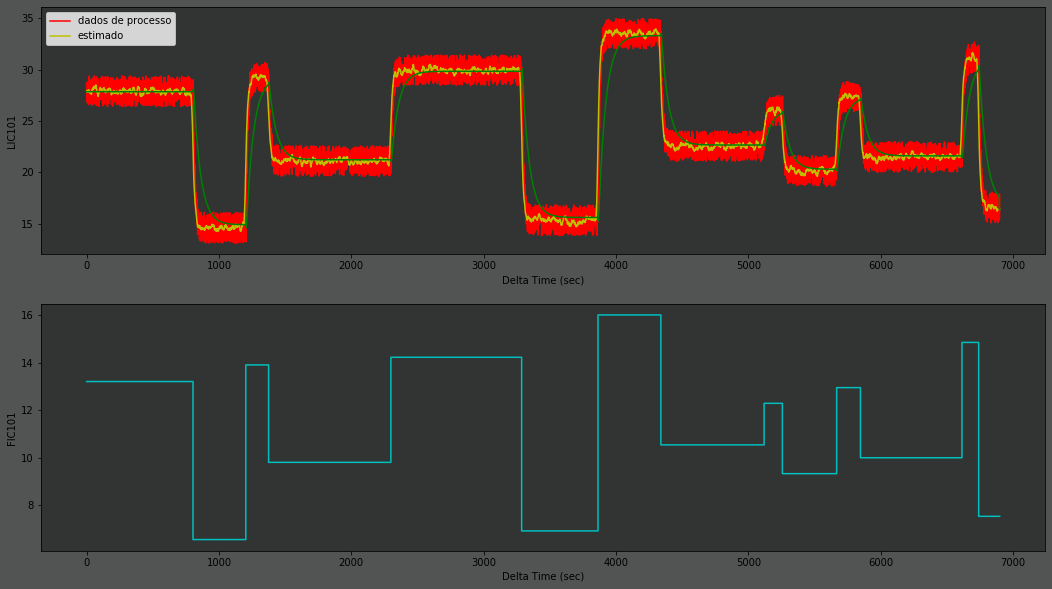

In [9]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(t,data_y['Value'],color='r',label='PV')
ax[0].plot(t,y_k+yb,color='y',label='PV')
ax[0].plot(t,y_h+yb,'g',label='PVf')
ax[0].set_xlabel('Delta Time (sec)')
ax[0].set_ylabel(bv_LIC101.name)
ax[1].step(t,u_k+ub, where='pre', color='c',label='MV')
ax[1].set_xlabel('Delta Time (sec)')
ax[1].set_ylabel(bv_FIC101.name)
fig.set_size_inches(18, 10)
fig.patch.set_facecolor('#525454')
ax[0].set_facecolor('#323434')
ax[1].set_facecolor('#323434')
ax[0].legend(['dados de processo', 'estimado'])

## ATENÇÃO

Este foi um exemplo simplificado do processo de identificação de sistemas dinâmicos - com foco na compreensão dos conceitos básicos e se ter uma ideia de como funcionam estes algoritmos, no caso, usando apenas o módulo NUMPY.

Em um processo de identificação de sistemas, existem algumas etapas que devem ser observadas, muitas delas exemplificadas neste arquivo, como a seleção e leitura dos dados de processo do período dos testes, visualização dos mesmos, tratamento dos dados (filtro de ruído, remoção do valor de referência-bias) e estimação dos parâmetros do modelo.

Os aspectos que não foram abordados, porém devem ser observados são:
* Planejamento dos experimentos e acompanhamento/realização dos mesmos (anotações de anomalias, questões operacionais, etc.)
* Validação do modelo estimado (simular com outros conjuntos de dados, etc.)

Para uso em produção (na prática), é recomendado utilizar algoritmos desenvolvidos com este objetivo (robustos, eficientes, etc.), como por exemplo, o módulo "Systems Identification Package for PYthon (SIPPY)" - e não fazer "à mão" como neste documento! :)

#### DICAS

[Exemplos no GitHub da Elipse Software](https://nbviewer.jupyter.org/github/elipsesoftware/epmwebapi/tree/master/exemplos/)

[EPM para analistas de dados: análises preliminares utilizando o módulo pandas da linguagem Python](https://youtu.be/DPrZv80fOuw)

[Webinar - Agilizando análises no EPM com o poder da linguagem Python](https://youtu.be/1u9z6YD_2P0)

[Webinar - Análise de Dados com Python e Dashboard Web](https://youtu.be/IYg5yutkIhw)

[Systems Identification Package for PYthon (SIPPY)](https://github.com/CPCLAB-UNIPI/SIPPY)